In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_json('image-data.json')
df.head()

,artists,comments,faves,image_paths,image_urls
0,get-sherlock,22,142,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
1,WuLiao-Yuzi,69,"2,110",[full/ba47403c06820d230acd79405fb8f1cf1e58c6fe...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
2,Moniqua1213,11,218,[full/b6465a0251d8d7381d2e108b3d8ec1e4767cb727...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
3,Gigei,66,883,[full/a212ffab3456626f176885fe1d5dcb5fc9fa0f0c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...
4,403shiomi,48,490,[full/6c05caa5b126250613307f70e506f07f1e2513c3...,[https://images-wixmp-ed30a86b8c4ca887773594c2...


In [3]:
#convert faves and comments to int
df['faves'] = df['faves'].str.replace(',', '').astype(int)
df['comments'] = df['comments'].str.replace(',', '').astype(int)

In [4]:
#look at top 15 artists sorted by total number of favorites and comments
#number of images within the database
df.groupby('artists').agg({'faves':sum,
                           'comments': 'sum',
                           'image_urls':'count',
                          }).sort_values(by=['faves','comments','image_urls'], ascending=False).head(15)


,faves,comments,image_urls
artists,,,
maXKennedy,43670,4901,54
dauntingfire,42467,3865,22
AmandaTolleson,38604,3944,11
mlcamaro,29561,1050,14
alicexz,23482,1144,3
hoo0,17311,885,3
xanseviera,15592,1022,10
sakimichan,10924,451,1
RoryonaRainbow,8791,451,3


In [5]:
from skimage.transform import resize
import matplotlib.image as mpimg

#create empty image lists
image_resized_lst = []
image_original_lst = []

#height and width of resized image
new_height = 250
new_width = 250


#image loading has to be done one-by-one to ensure that the images are loaded in the corresponding order to the
#data collected in the dataframe
for i in range(len(df)):
    my_dir = 'DA-images/'
    img_path = df['image_paths'][i][0]
    #load image
    img = mpimg.imread(my_dir + img_path)
    image_original_lst.append(img)
    #resize image
    img_resized = resize(img,(new_height,new_width),
                        mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    image_resized_lst.append(img_resized)
    
original_arr = np.array(image_original_lst)
resized_arr = np.array(image_resized_lst)

In [6]:
print(f"Original images array shape: {original_arr.shape}\nResized images array shape: {resized_arr.shape}")

Original images array shape: (1771,)
Resized images array shape: (1771, 250, 250, 3)


Text(0,0.5,'Images Resized')

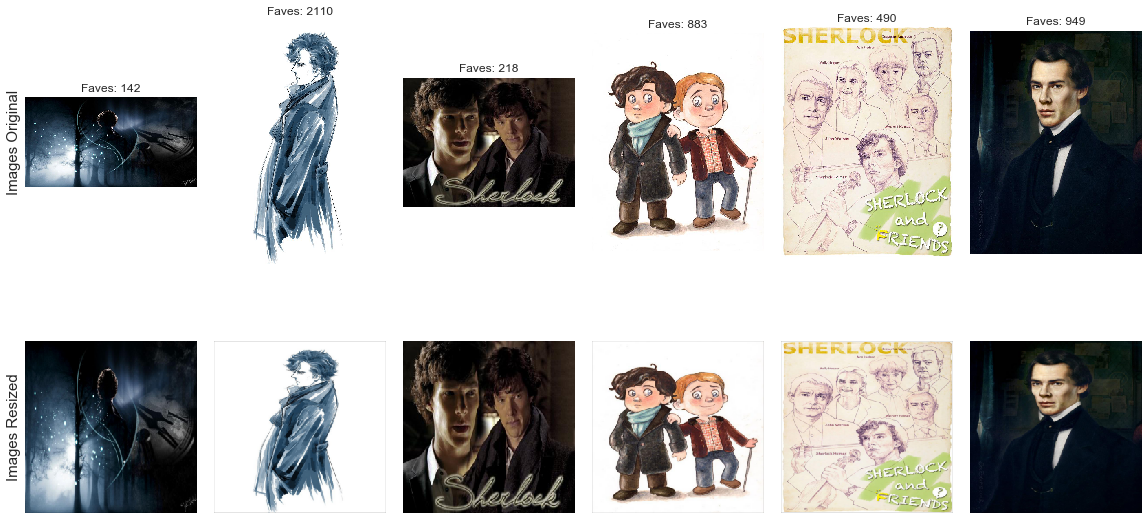

In [7]:
#peak at the resized images vs original images
fig, ax = plt.subplots(2, 6, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(6):
    ax[0, i].imshow(original_arr[i])
    ax[1, i].imshow(resized_arr[i])
    ax[0, i].set_title(f"Faves: {df.faves[i]}")
    
ax[0, 0].set_ylabel('Images Original',size=15)
ax[1, 0].set_ylabel('Images Resized',size=15)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor

input_shape = (250,250,3)

def baseline_model():
    # create model
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(9, 9), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
# build regression estimator
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=20, verbose=1, validation_split=0.33)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = resized_arr
y = np.array(df['faves'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1416, 250, 250, 3) (355, 250, 250, 3) (1416,) (355,)


In [11]:
estimator.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 948 samples, validate on 468 samples
Epoch 1/100
948/948 [==============================] - 144s 152ms/step - loss: 554293.9533 - val_loss: 1128241.5225
Epoch 2/100
948/948 [==============================] - 122s 129ms/step - loss: 529079.3181 - val_loss: 1154130.9719
Epoch 3/100
948/948 [==============================] - 128s 135ms/step - loss: 530320.8868 - val_loss: 1123141.1356
Epoch 4/100
948/948 [==============================] - 124s 131ms/step - loss: 523492.9441 - val_loss: 1118964.4432
Epoch 5/100
948/948 [==============================] - 130s 137ms/step - loss: 519053.2486 - val_loss: 1122415.9635
Epoch 6/100
948/948 [==============================] - 125s 132ms/step - loss: 511257.8292 - val_loss: 1114721.9997
Epoch 7/100
948/948 [==

948/948 [==============================] - 119s 125ms/step - loss: 7602.3693 - val_loss: 1191655.1052
Epoch 64/100
948/948 [==============================] - 121s 128ms/step - loss: 5242.9955 - val_loss: 1188685.6851
Epoch 65/100
948/948 [==============================] - 126s 133ms/step - loss: 5217.8896 - val_loss: 1194717.0828
Epoch 66/100
948/948 [==============================] - 115s 121ms/step - loss: 7805.2476 - val_loss: 1195144.5445
Epoch 67/100
948/948 [==============================] - 110s 116ms/step - loss: 7552.1241 - val_loss: 1184267.5897
Epoch 68/100
948/948 [==============================] - 119s 126ms/step - loss: 5927.1513 - val_loss: 1193381.6660
Epoch 69/100
948/948 [==============================] - 119s 126ms/step - loss: 5126.8154 - val_loss: 1189032.6468
Epoch 70/100
948/948 [==============================] - 116s 122ms/step - loss: 5665.9108 - val_loss: 1190974.5248
Epoch 71/100
948/948 [==============================] - 116s 123ms/step - loss: 5997.3277 - v

1416/1416 [==============================] - 52s 37ms/step
Explained variance score: 0.4362503938507125
Mean absolute score: 188.0037480451293


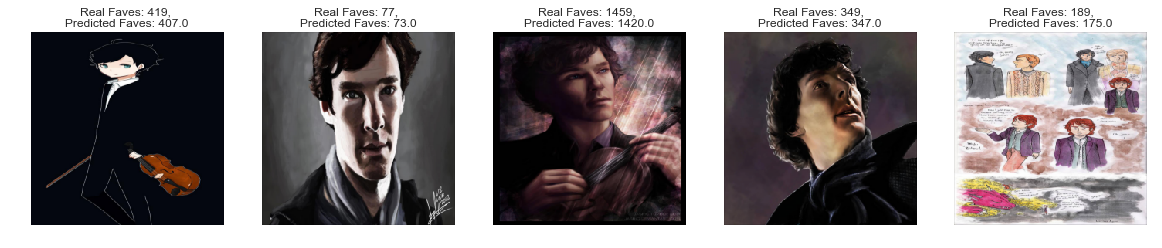

In [14]:
prediction = estimator.predict(X_train)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_train[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_train[i])
    
print(f"Explained variance score: {explained_variance_score(y_train, prediction)}")
print(f"Mean absolute score: {mean_absolute_error(y_train, prediction)}")

355/355 [==============================] - 13s 36ms/step
Explained variance score: -0.08006009496999122
Mean absolute error: 539.6256879093781


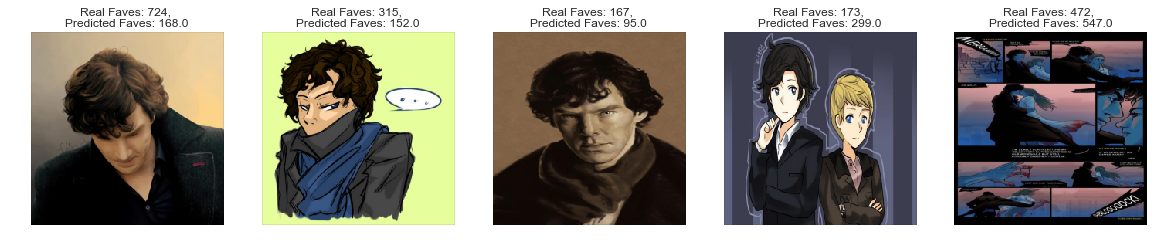

In [19]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

prediction = estimator.predict(X_test)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_test[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_test[i])
    
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_test, prediction)}")

Ideas to improve the model:
- only select pics of a certain dimension? e.g. filter out pics that are too long or too tall.